In [1]:
import numpy as np

from mcap.reader import make_reader
from mcap_ros1.decoder import DecoderFactory

import matplotlib.pyplot as plt 
from matplotlib.collections import LineCollection



action_topic = "/vesc/high_level/ackermann_cmd_mux/input/nav_1"
odom_topic = "/car_state/odom"
file_name = "demo.mcap"


(858, 462)
25245
0
1952.8378818151546


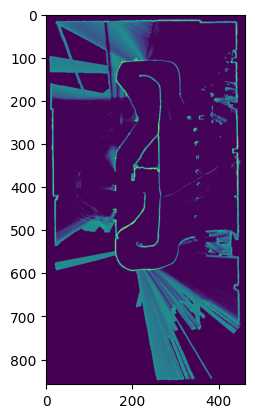

In [5]:
def extract_track_map():
    map_topic = "/map"
    file_name = "RawData/demo.mcap"

    map_extracted = False
    map_info = {}
    with open(file_name, "rb") as f:
        reader = make_reader(f, decoder_factories=[DecoderFactory()])
        for schema, channel, message, proto_msg in reader.iter_decoded_messages():
            
            if channel.topic == map_topic and not map_extracted:
                map_info["resolution"] = proto_msg.info.resolution
                width = proto_msg.info.width
                height = proto_msg.info.height
                map_info["origin"] = [proto_msg.info.origin.position.x, proto_msg.info.origin.position.y, proto_msg.info.origin.position.z]

                map_img = np.reshape(proto_msg.data, (height, width))
                print(np.shape(map_img))

                map_extracted = True

    import yaml 
    map_name = "eth_fast_track"
    with open(f"maps/{map_name}.yaml", "w") as f:
        yaml.dump(map_info, f)

    plt.figure()
    plt.imshow(map_img)

    map_img[np.where(map_img < 0)] = 0
    map_img[np.where(map_img > 0)] = 255 * map_img[np.where(map_img > 0)]

    print(np.max(map_img))
    print(np.min(map_img))
    print(np.mean(map_img))

    from PIL import Image
    map_img = Image.fromarray(map_img.astype(np.uint8))
    map_img.save(f"maps/{map_name}.png")
    




extract_track_map()



In [ ]:
def make_timed_data_set():
    actions = []
    states = []
    action_times = []
    states_times = []
    init_time = None
    with open(file_name, "rb") as f:
        reader = make_reader(f, decoder_factories=[DecoderFactory()])
        for schema, channel, message, proto_msg in reader.iter_decoded_messages():
            if init_time is None:
                if channel.topic == action_topic or channel.topic == odom_topic:
                    init_time = proto_msg.header.stamp.secs + proto_msg.header.stamp.nsecs * 1e-9 # add print line
                    print(f"Initial time: {init_time}") # add print line

            if channel.topic == action_topic:

                speed = proto_msg.drive.speed
                steering = proto_msg.drive.steering_angle
                action = np.array([steering, speed])
                actions.append(action)
                msg_time = proto_msg.header.stamp.secs + proto_msg.header.stamp.nsecs * 1e-9 # add print line
                action_times.append(msg_time - init_time)

            if channel.topic == odom_topic:
                x = proto_msg.pose.pose.position.x
                y = proto_msg.pose.pose.position.y

                oz = proto_msg.pose.pose.orientation.z
                ow = proto_msg.pose.pose.orientation.w

                v = proto_msg.twist.twist.linear.x

                odom = np.array([x, y, oz, ow, v])
                states.append(odom)
                msg_time = proto_msg.header.stamp.secs + proto_msg.header.stamp.nsecs * 1e-9 # add print line
                states_times.append(msg_time - init_time)

    actions = np.stack(actions)
    states = np.stack(states)

    action_times = np.stack(action_times)
    states_times = np.stack(states_times)

    return states, actions, states_times, action_times



In [ ]:
states, actions, states_times, actions_times = make_timed_data_set()

print(f"Actions shape: {actions.shape}")
print(f"States shape: {states.shape}")

action_dt = np.diff(actions_times)
states_dt = np.diff(states_times)

print(f"Average action time: {np.mean(action_dt)}")
print(f"Max action time: {np.max(action_dt)}")
print(f"Min action time: {np.min(action_dt)}")

print(f"Average state time: {np.mean(states_dt)}")
print(f"Max state time: {np.max(states_dt)}")
print(f"Min state time: {np.min(states_dt)}")



Initial time: 1653028975.2518806
Actions shape: (845, 2)
States shape: (2696, 5)
Average action time: 0.04000030196673497
Max action time: 0.05809497833251953
Min action time: 0.016281843185424805
Average state time: 0.01252192787425195
Max state time: 0.0977621078491211
Min state time: 0.0


Initial time: 1653028975.2518806


(-3.6077922629662966,
 3.9766666101496737,
 -1.0209789730422654,
 22.6121548630781)

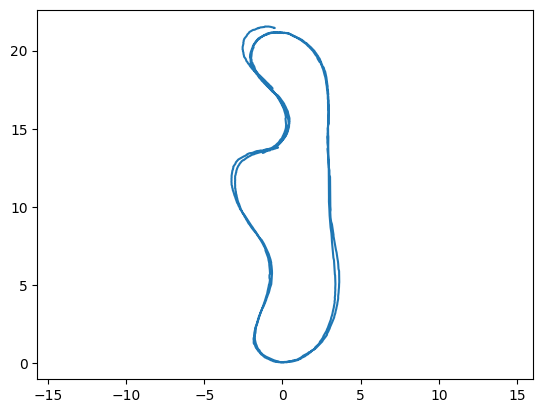

In [ ]:
states, actions, states_times, actions_times = make_timed_data_set()

# quats = states[:, 2:4]


# plt.figure(figsize=(10, 10))
plt.plot(states[:, 0], states[:, 1], label="States")

plt.axis("equal")


Initial time: 1653028975.2518806


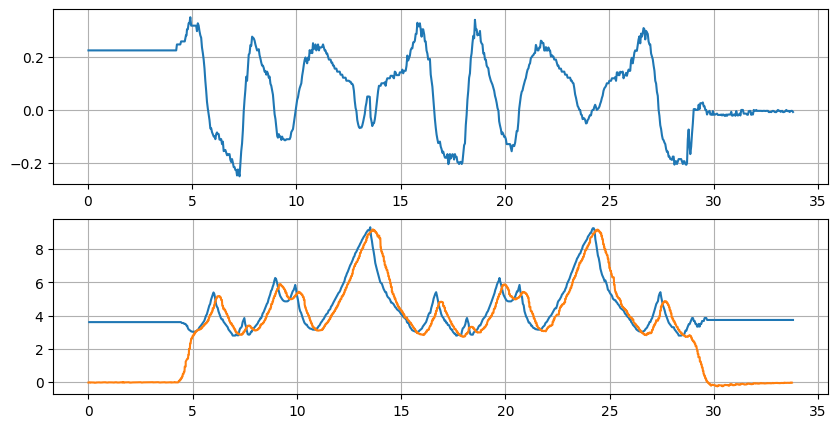

In [ ]:
states, actions, states_times, actions_times = make_timed_data_set()

fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(actions_times, actions[:, 0], label="Steering")
axs[0].grid(True)

axs[1].plot(actions_times, actions[:, 1], label="Speed")
axs[1].plot(states_times, states[:, 4], label="Speed from state")
axs[1].grid(True)

def extract_angles(quats):
    """
    Extracts the angles from a quaternion list.
    """
    return np.array([np.arctan2(q[1], q[0]) for q in quats])

Initial time: 1653028975.2518806


(-0.6217122405618849,
 0.11526276057403667,
 -0.3312820372560306,
 0.5997771201708673)

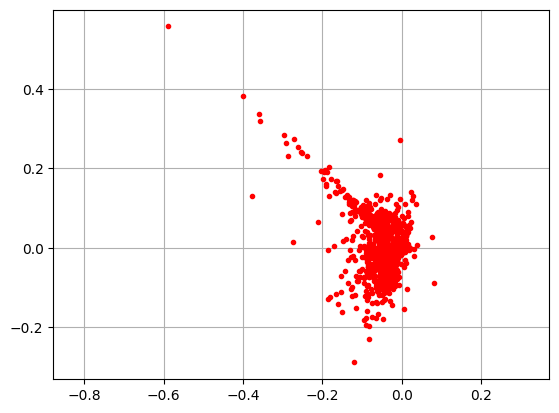

In [ ]:
states, actions, states_times, actions_times = make_timed_data_set()

angles = np.arctan2(states[:, 3], states[:, 2]) 
d_pos = np.diff(states[:, 0:2], axis=0)

class Rz:
    def __init__(self, angle):
        self.angle = angle

    def __call__(self, x):
        R = np.array([[np.cos(self.angle), -np.sin(self.angle)], [np.sin(self.angle), np.cos(self.angle)]])
        return np.matmul(R, x)

for i in range(1, len(d_pos)):
    # d_pos[i, :] = np.matmul(Rz(angles[i]), d_pos[i, :])
    r = Rz(angles[i-1])
    d_pos[i, :] = r(d_pos[i, :])

plt.plot(d_pos[:, 0], d_pos[:, 1], '.', color='red')
plt.grid(True)
plt.axis("equal")




In [ ]:
import math
 
def euler_from_quaternion(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
     
        return roll_x, pitch_y, yaw_z # in radians

Initial time: 1653028975.2518806
(2696, 2)
[[ 0.          0.        ]
 [-0.00067935  0.00048332]
 [-0.0004361   0.00031027]
 [-0.00069036  0.00049117]
 [ 0.00452744 -0.0024671 ]]
(2695, 2)
[[ 0.00563413 -0.01637649]
 [-0.00433049  0.01124864]
 [ 0.00829531 -0.00371732]
 [ 0.03191207 -0.01023685]
 [-0.04629454  0.003241  ]
 [-0.03235692 -0.00948035]
 [ 0.05921191  0.00477588]
 [-0.03427521  0.00355179]
 [ 0.03406063 -0.00491853]]


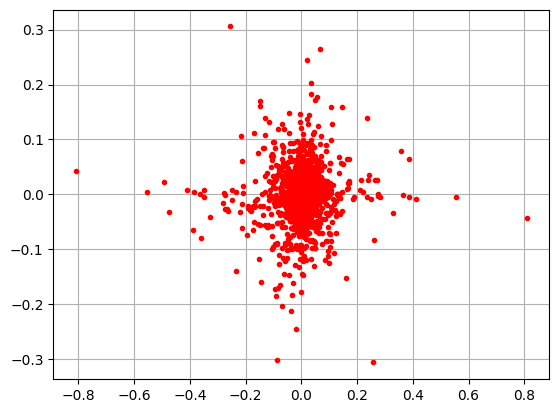

In [ ]:
states, actions, states_times, actions_times = make_timed_data_set()

positions = states[:, :2]
orientation_quats = states[:, 2:4]

# Convert quaternions to euler angles


positions = states[:, :2]
orientation_quats = states[:, 2:4]

# Convert quaternions to euler angles
transformed_poses = np.zeros_like(positions)
yaws = np.zeros_like(positions[:, 0])
for i in range(1, positions.shape[0]):
    _, _, yaw = euler_from_quaternion(0, 0, orientation_quats[i-1, 0], orientation_quats[i-1, 1])
    yaws[i] = yaw
    rotation_matrix = np.array([[np.cos(yaw), -np.sin(yaw)],
                                [np.sin(yaw), np.cos(yaw)]])

    pt = positions[i] - positions[i-1]
    transformed_poses[i] = np.matmul(pt, rotation_matrix.T).T

    # print(f"Original point: {positions[i-1]}")
    # print(f"New point: {positions[i]}")
    # print(f"Difference: {pt}")
    # print(f"Transformed Pose: {transformed_poses[i]}")


print(transformed_poses.shape)
print(transformed_poses[:5])

d_poses = np.diff(transformed_poses, axis=0)
print(d_poses.shape)
print(d_poses[1000:1009])
d_poses = d_poses[d_poses[:, 1] > -20]

# plt.plot(yaws)

plt.plot(d_poses[:, 0], d_poses[:, 1], '.', color='red')
plt.grid(True)
# plt.axis("equal")


## Problems identified
- The graph should have all the distances in positive terms.
- I am expecting the difference between points to always be in front of the vehicle.
- There must be a problem with how I am transforming them....


Initial time: 1653028975.2518806


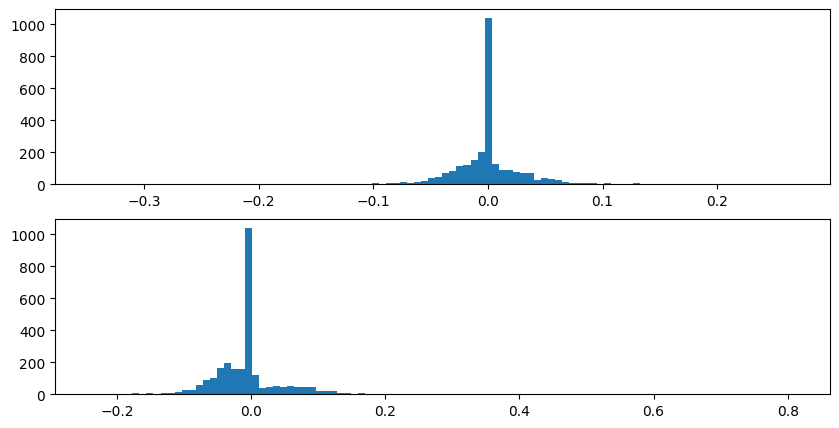

In [ ]:
states, actions, states_times, actions_times = make_timed_data_set()

d_x = np.diff(states[:, 0])
d_y = np.diff(states[:, 1])


fig, axs = plt.subplots(2, 1, figsize=(10, 5))

hx = axs[0].hist(d_x, bins=100)

hy = axs[1].hist(d_y, bins=100)
